# 基于`transformer`的中译英模型
[原始Google链接](https://tensorflow.google.cn/tutorials/text/transformer#%E4%BC%98%E5%8C%96%E5%99%A8%EF%BC%88optimizer%EF%BC%89)
  
目录：


In [22]:
import io
import re
import jieba
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import zhconv
from sklearn.model_selection import train_test_split

In [23]:
plt.rcParams['font.sans-serif']=['SimHei']
tf.__version__

'2.0.0'

## 一、语料数据处理及向量化
原始语料每一行为一条中文短句及对应的英文翻译，两者通过 `\t` 隔开

In [24]:
data_dir = '../H/datasets/cmn-eng/cmn.txt'

In [25]:
io.open(data_dir, encoding='utf-8').readlines()[:5]

['Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)\n',
 'Hi.\t你好。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)\n',
 'Run.\t你用跑的。\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #3748344 (egg0073)\n',
 'Wait!\t等等！\tCC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #4970122 (wzhd)\n',
 'Wait!\t等一下！\tCC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #5092613 (mirrorvan)\n']

In [26]:
# 英文处理
def preprocess_eng(w):
    w = w.lower().strip()

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r"\1 ", w)
    w = re.sub(r"[' ']+", " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记，以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [27]:
# 中文处理
def preprocess_zh(w):
    w = zhconv.convert(w, "zh-cn")
    w = ' '.join(jieba.cut(w))
    w = w.rstrip().strip()
    w = "<start> " + w + " <end>"
    return w

In [28]:
# 原始语料预处理
def create_dataset(data_dir, num_examples):
    lines = io.open(data_dir, encoding='utf-8').read().strip().split('\n')
    eng, zh = [], []
    for line in lines[:num_examples]:
        word_pairs = line.split("\t")
        eng.append(preprocess_eng(word_pairs[0]))
        zh.append(preprocess_zh(word_pairs[1]))
    return [eng, zh]

In [29]:
eng, zh = create_dataset(data_dir, None)
print(eng[-1])
print(zh[-1])

<start> if a person has not had a chance to acquire his target language by the time he s an adult, he s unlikely to be able to reach native speaker level in that language. <end>
<start> 如果 一个 人 在 成人 前 没有 机会 习得 目标语言 ， 他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 。 <end>


In [30]:
# 文本向量化
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding="post")
    return tensor, lang_tokenizer

In [31]:
def load_dataset(data_dir, num_examples=None):
    eng, zh = create_dataset(data_dir, num_examples)
    zh_tensor, zh_tokenizer = tokenize(zh)
    eng_tensor, eng_tokenizer = tokenize(eng)
    return zh_tensor, zh_tokenizer, eng_tensor, eng_tokenizer

In [32]:
num_examples = None
zh_tensor, zh_tokenizer, eng_tensor, eng_tokenizer = load_dataset(data_dir, num_examples)

In [33]:
# KEY：将分词器保存，方便后续使用

tokenizer_dir = '../H/save/zh2eng_transformer_tokenizer/'
zh_tokenizer_dir = tokenizer_dir + 'zh_tokenizer.json'
eng_tokenizer_dir = tokenizer_dir + 'eng_tokenizer.json'

tokenizer_json = zh_tokenizer.to_json()
with io.open(zh_tokenizer_dir, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

tokenizer_json = eng_tokenizer.to_json()
with io.open(eng_tokenizer_dir, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [34]:
# # 载入分词器
# # from tensorflow.keras.preprocessing.text import tokenizer_from_json
# # 2.0.0 版本没有这个函数

# from tensorflow.keras.preprocessing.text import Tokenizer
# import json
# def tokenizer_from_json(json_string):
#     """Parses a JSON tokenizer configuration file and returns a
#     tokenizer instance.

#     # Arguments
#         json_string: JSON string encoding a tokenizer configuration.

#     # Returns
#         A Keras Tokenizer instance
#     """
#     tokenizer_config = json.loads(json_string)
#     config = tokenizer_config.get('config')

#     word_counts = json.loads(config.pop('word_counts'))
#     word_docs = json.loads(config.pop('word_docs'))
#     index_docs = json.loads(config.pop('index_docs'))
#     # Integer indexing gets converted to strings with json.dumps()
#     index_docs = {int(k): v for k, v in index_docs.items()}
#     index_word = json.loads(config.pop('index_word'))
#     index_word = {int(k): v for k, v in index_word.items()}
#     word_index = json.loads(config.pop('word_index'))

#     tokenizer = Tokenizer(**config)
#     tokenizer.word_counts = word_counts
#     tokenizer.word_docs = word_docs
#     tokenizer.index_docs = index_docs
#     tokenizer.word_index = word_index
#     tokenizer.index_word = index_word

#     return tokenizer


# tokenizer_dir = '../H/save/zh2eng_transformer_tokenizer/'
# zh_tokenizer_dir = tokenizer_dir + 'zh_tokenizer.json'
# eng_tokenizer_dir = tokenizer_dir + 'eng_tokenizer.json'

# with open(zh_tokenizer_dir) as f:
#     data = json.load(f)
#     zh_tokenizer = tokenizer_from_json(data)

# with open(eng_tokenizer_dir) as f:
#     data = json.load(f)
#     zh_tokenizer = tokenizer_from_json(data)

In [35]:
print(zh_tensor.shape, eng_tensor.shape)

(21621, 30) (21621, 36)


In [36]:
# 拆分训练集与测试集
zh_tensor_train, zh_tensor_val, eng_tensor_train, eng_tensor_val = train_test_split(
    zh_tensor, eng_tensor, test_size=0.2)

In [37]:
print(len(zh_tensor_train), len(zh_tensor_val))

17296 4325


In [38]:
def convert(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print("%d ---> %s" % (t, tokenizer.index_word[t]))


print("Input Language; index to word mapping")
convert(zh_tokenizer, zh_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(eng_tokenizer, eng_tensor_train[0])

Input Language; index to word mapping
1 ---> <start>
4 ---> 我
12 ---> 是
7 ---> 你
5 ---> 的
2381 ---> 伙伴
3 ---> 。
2 ---> <end>

Target Language; index to word mapping
1 ---> <start>
3 ---> i
36 ---> m
27 ---> your
3917 ---> partner.
2 ---> <end>


In [39]:
BUFFER_SIZE = len(zh_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(zh_tensor_train) // BATCH_SIZE

embedding_size = 256
# units = 1024
zh_vocab_size = len(zh_tokenizer.word_index) + 1
eng_vocab_size = len(eng_tokenizer.word_index) + 1

zh_vocab_size, eng_vocab_size

(10696, 9756)

In [40]:
# 创建 tf.dataset 数据集
dataset = tf.data.Dataset.from_tensor_slices(
    (zh_tensor_train, eng_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(
    tf.data.experimental.AUTOTUNE)

In [41]:
example_zh_batch, example_eng_batch = next(iter(dataset))
print(example_zh_batch.shape, example_eng_batch.shape)

(64, 30) (64, 36)


## 二、位置编码(Positional encoding)
对 token 序列中，每个 token 所处的位置信息进行编码，每个位置编码成一个维度为 d_model 的向量
      
$PE_{(pos, 2i)} = sin(pos/10000^{2i/d\_model})$
     
$PE_{(pos, 2i+1)} = sin(pos/10000^{2i/d\_model})$


In [42]:
def get_angles(pos, i, d_model):
    """
    pos:     [seq_len, 1]
    i:       [1, d_model]
    d_model: int 
    return:  [seq_len, d_model]
    """
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [43]:
def positional_encoding(position, d_model):
    # 位置总数 position 个，每个位置编码成 d_model 维向量
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :], d_model)

    # 将 sin 应用于 d_model 维中的偶数索引
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于 d_model 维中的偶数索引
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # 返回：[1, position, d_model]
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [44]:
pos_encoding = positional_encoding(30, 512)
print(pos_encoding.shape)

(1, 30, 512)


/home/yangbin7/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yangbin7/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


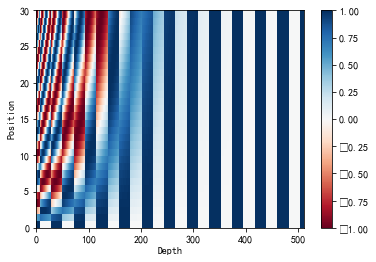

In [45]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 三、遮挡（Masking）：遮挡序列中满足特定条件的标记
1. 遮挡值为 0 的标记
2. 前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。
   
>例如序列生成中：   
当要预测第三个词时，将仅使用第一个和第二个词，后续所有词被遮挡；     
与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [46]:
def create_padding_mask(seq):
    # 将 seq 序列中为 0 的位置标记为 1，其它的位置标记为 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# 增加到 4 维，是因为注意力权重形状为 [batch_size, num_heads, seq_len, seq_len]

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=56, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [47]:
def create_look_ahead_mask(size):
    # tf.linalg.band_part: 以对角线为中心，取指定带宽的上三角和下三角，其它数据 0 填充
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


x = tf.random.uniform((1, 3))
print(create_look_ahead_mask(x.shape[1]))

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


## 四、按比例缩放的点积注意力(Scaled dot product attention)
- 原理如下图所示：
![](images/scaled_attention.png)
注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））.用于计算注意力权重的等式为：
   
$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V $$
    
> 点积注意力被缩小了深度的平方根倍 $\sqrt{d_k}$。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

- 在机器翻译中，点积注意力的用法如下所示


![](images/scaled-dot-product-attention.png)

> 图中向量 $q_t$ 与 $K=[k_1, k_2, k_3, k_4]$ 每个向量做点积，然后转换为权重，权重值越大可以认为越“关注”该处的信息，然后每个位置的 $v$ 与该处的权重相乘，然后求和得到 $q_t$ 对 $K$ 做注意力的输出向量

In [97]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    :param q: (batch_size, seq_len_q, depth)
    :param k: (batch_size, seq_len_k, depth)
    :param v: (batch_size, seq_len_v, depth_v)
    :param mask: (batch_size, seq_len_q, deq_len_k)
    :return:
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # (..., seq_len_q, seq_len_k)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    print("shape of mask:", mask.shape)
    print("shape of atten:", scaled_attention_logits.shape)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        # 在待遮挡处减去一个较大值，softmax 即可忽略该位置

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)
    # (..., seq_len_q, depth_v)

    return output, attention_weights

In [49]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [50]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0], [0, 10, 0], [0, 0, 10], [0, 0, 10]],
                     dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0], [10, 0], [100, 5], [1000, 6]],
                     dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


## 五、多头注意力层（Multi-head attention）
- 多头注意力如下图所示：
![多头注意力](../images/multi_head_attention.png)
> Q、K、和 V 被拆分到了多个头，允许模型共同注意来自不同表示空间的不同位置的信息

In [51]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert self.d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(self.d_model)
        self.wk = tf.keras.layers.Dense(self.d_model)
        self.wv = tf.keras.layers.Dense(self.d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=(0, 2, 1, 3)) 
        #  (batch_size, num_heads, seq_len, depth)，便于计算

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)

        q = self.split_heads(
            q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(
            scaled_attention,
            perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        output = self.dense(
            concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

In [52]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)

In [53]:
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 六、点式前馈网络（Point wise feed forward network）
由两层全联接层组成，两层之间有一个 ReLU 激活函数

In [54]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)
        # (batch_size, seq_len, d_model)
    ])


sample_ffn = point_wise_feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


## 七、编码与解码（Encoder and decoder）
Transformer 模型与标准的具有注意力机制的序列到序列模型（sequence to sequence with attention model），遵循相同的一般模式。其结构如下所示：
![transformer](images/transformer.png)

#### 1. 编码器层（Encoder layer）

In [55]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x,mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [56]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)

(64, 43, 512)


#### 2. 解码器层（Decoder layer）

In [57]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [58]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None,
    None)

print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)

(64, 50, 512)


#### 3. 编码器

- 输入嵌入（Input Embedding）
- 位置编码（Positional Encoding）
- N 个编码器层（encoder layers）


In [59]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 maximum_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [60]:
sample_encoder = Encoder(num_layers=2,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)),
                                       training=False,
                                       mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


#### 4. 解码器（Decoder）
- 输出嵌入（Output Embedding）
- 位置编码（Positional Encoding）
- N 个解码器层（decoder layers）


In [61]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 target_vocab_size,
                 maximum_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                d_model)

        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask,
                                                   padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights

In [62]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048,
                         target_vocab_size=8000, maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)),
                              enc_output=sample_encoder_output, training=False,
                              look_ahead_mask=None, padding_mask=None)

print(output.shape, attn['decoder_layer2_block2'].shape)

(64, 26, 512) (64, 8, 26, 62)


## 八、Transformer


In [63]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 target_vocab_size,
                 pe_input,
                 pe_target,
                 rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask,
             dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_ouput, attention_weights = self.decoder(tar, enc_output, training,
                                                    look_ahead_mask,
                                                    dec_padding_mask)
        final_output = self.final_layer(dec_ouput)
        return final_output, attention_weights

In [64]:
sample_transformer = Transformer(num_layers=2,
                                 d_model=512,
                                 num_heads=8,
                                 dff=2048,
                                 input_vocab_size=8500,
                                 target_vocab_size=8000,
                                 pe_input=10000,
                                 pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input,
                               temp_target,
                               training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print(fn_out.shape)

(64, 26, 8000)


## 九、配置超参数

In [65]:
num_layers = 4  
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(zh_tokenizer.word_index) + 1
target_vocab_size = len(eng_tokenizer.word_index) + 1
dropout_rate = 0.1

## 十、优化器（Optimizer）
将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用: 

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [67]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

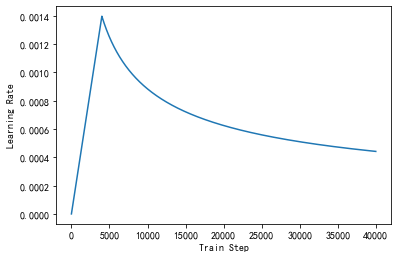

In [68]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## 十一、损失函数与指标（Loss and metrics）
由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [69]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 十一、训练与检查点(Training and checkpointing)

In [70]:
transformer = Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)


# TODO：各有什么作用？？
def create_masks(inp, tar):
    # inp:(batch_size, seq_len_inp)
    # tar:(batch_size, seq_len_tar - 1)
    
    # 1,编码器填充遮挡，将输入序列 pad 的部分填充掉:
    # (batch_size, 1, 1, seq_len_inp)
    enc_padding_mask = create_padding_mask(inp)
    
    # 2,用于解码器对编码器的输入进行注意力做 mask，因此维度为 seq_len_inp
    # (batch_size, 1, 1, seq_len_inp)，    
    dec_padding_mask = create_padding_mask(inp)

    # 3. 不仅遮挡输入末尾填充（pad）的 0，还要遮挡输入的后续标记（future tokens）：
    # (seq_len_tar - 1, seq_len_tar - 1)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    # (batch_size, 1, 1, seq_len_tar - 1)
    dec_target_padding_mask = create_padding_mask(tar)
    
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask


checkpoint_path = "../H/save/zh2eng_transformer"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

序列长度为 5 的 `look_ahead_mask`:
$$
[0, 1, 1, 1, 1] \\
[0, 0, 1, 1, 1] \\
[0, 0, 0, 1, 1] \\ 
[0, 0, 0, 0, 1] \\
[0, 0, 0, 0, 0] \\
$$
    
对应的代表填充后 3 位得到的序列，`dec_target_padding_mask[x,:,:,:]`:
$$[0, 0, 1, 1, 1] $$
    
最终得到的 `combined_mask` 为：
$$
[0, 1, 1, 1, 1] \\
[0, 0, 1, 1, 1] \\
[0, 0, 1, 1, 1] \\ 
[0, 0, 1, 1, 1] \\
[0, 0, 1, 1, 1] \\
$$


In [87]:
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
    example_zh_batch, tar_inp)

In [98]:
predictions, _ = transformer(example_zh_batch, tar_inp, True, enc_padding_mask,
                                 combined_mask, dec_padding_mask)

shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 30, 30)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 30, 30)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 30, 30)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 30, 30)
shape of mask: (64, 1, 35, 35)
shape of atten: (64, 8, 35, 35)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 35, 30)
shape of mask: (64, 1, 35, 35)
shape of atten: (64, 8, 35, 35)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 35, 30)
shape of mask: (64, 1, 35, 35)
shape of atten: (64, 8, 35, 35)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 35, 30)
shape of mask: (64, 1, 35, 35)
shape of atten: (64, 8, 35, 35)
shape of mask: (64, 1, 1, 30)
shape of atten: (64, 8, 35, 30)


In [96]:
predictions

<tf.Tensor: id=9139, shape=(64, 35, 9756), dtype=float32, numpy=
array([[[-0.1282706 ,  0.10864322, -0.24248649, ...,  0.16296358,
          0.1459565 , -0.34566465],
        [-0.0717675 ,  0.18643032, -0.08001041, ...,  0.09116092,
          0.11926436, -0.34716186],
        [-0.02932605,  0.0366094 , -0.21726583, ...,  0.1092973 ,
          0.21624133, -0.35436305],
        ...,
        [-0.1644766 ,  0.13415962, -0.15722702, ...,  0.13606192,
          0.1721753 , -0.3274525 ],
        [-0.2355859 ,  0.09242162, -0.1662194 , ...,  0.09706165,
          0.0351093 , -0.30270767],
        [-0.16192722,  0.10823155, -0.15517114, ...,  0.11812331,
          0.18167779, -0.40581176]],

       [[-0.32617697,  0.22187786, -0.09803833, ...,  0.08348731,
          0.04196617, -0.2595157 ],
        [-0.12240703,  0.2136595 , -0.12586969, ...,  0.05328099,
          0.05000972, -0.2488268 ],
        [-0.12685798,  0.09253548, -0.05003348, ...,  0.01079748,
          0.13053499, -0.31164265],
  

In [71]:
EPOCHS = 20

In [52]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。


@tf.function()
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]   # 给定前面的词，预测下一个词

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask,
                                     combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [53]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> zh, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(
            epoch + 1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0904 Accuracy 0.0000
Epoch 1 Batch 50 Loss 1.9386 Accuracy 0.0105
Epoch 1 Batch 100 Loss 1.9165 Accuracy 0.0194
Epoch 1 Batch 150 Loss 1.8870 Accuracy 0.0225
Epoch 1 Batch 200 Loss 1.8540 Accuracy 0.0240
Epoch 1 Batch 250 Loss 1.8171 Accuracy 0.0249
Epoch 1 Loss 1.7999 Accuracy 0.0252
Time taken for 1 epoch: 15.697981119155884 secs

Epoch 2 Batch 0 Loss 1.5492 Accuracy 0.0286
Epoch 2 Batch 50 Loss 1.5150 Accuracy 0.0286
Epoch 2 Batch 100 Loss 1.4675 Accuracy 0.0286
Epoch 2 Batch 150 Loss 1.4216 Accuracy 0.0286
Epoch 2 Batch 200 Loss 1.3878 Accuracy 0.0286
Epoch 2 Batch 250 Loss 1.3627 Accuracy 0.0295
Epoch 2 Loss 1.3537 Accuracy 0.0300
Time taken for 1 epoch: 8.945199728012085 secs

Epoch 3 Batch 0 Loss 1.1658 Accuracy 0.0375
Epoch 3 Batch 50 Loss 1.1896 Accuracy 0.0433
Epoch 3 Batch 100 Loss 1.1671 Accuracy 0.0470
Epoch 3 Batch 150 Loss 1.1501 Accuracy 0.0492
Epoch 3 Batch 200 Loss 1.1343 Accuracy 0.0512
Epoch 3 Batch 250 Loss 1.1194 Accuracy 0.0529
Epoch 3 Loss

## 十二、评估

In [66]:
max_length_ch = zh_tensor.shape[-1]
max_length_eng = eng_tensor.shape[-1]


def evaluate(inp_sentence):
    sentence = preprocess_zh(inp_sentence)
    inputs = [zh_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_length_ch, padding='post')
    encoder_input = tf.convert_to_tensor(inputs)

    # encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [eng_tokenizer.word_index['<start>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(max_length_eng):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, output,
                                                     False, enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == eng_tokenizer.word_index['<end>']:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [67]:
def plot_attention_weights(attention, sentence, result, layer):
    print(result)

    fig = plt.figure(figsize=(16, 8))

    sentence = preprocess_zh(sentence)
    sentence = [zh_tokenizer.word_index[i] for i in sentence.split(' ')]

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)
        ax.set_xlim(-0.5, len(sentence))

        ax.set_xticklabels([zh_tokenizer.index_word[i] for i in sentence],
                           fontdict=fontdict)

        ax.set_yticklabels(
            [eng_tokenizer.index_word[i] for i in result.numpy()] + ['<end>'],
            fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

    plt.tight_layout()
    plt.show()

In [72]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = ' '.join(
        [eng_tokenizer.index_word[i] for i in result.numpy()[1:]])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

Input: 你应该立即开始。
Predicted translation: port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port port
tf.Tensor(
[   1 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771
 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771 6771
 6771 6771 6771 6771 6771 6771 6771 6771 6771], shape=(37,), dtype=int32)


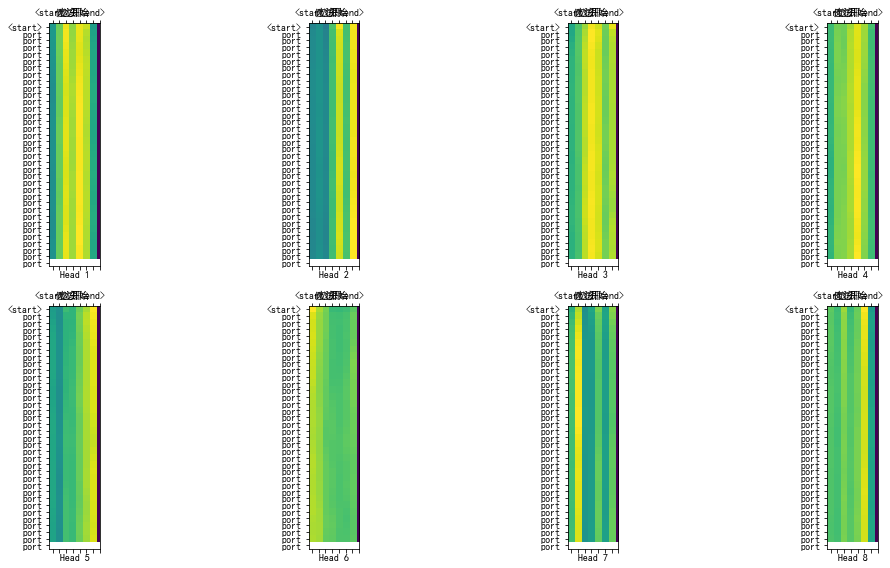

Real translation: you should begin right away.


In [76]:
translate("你应该立即开始。", plot='decoder_layer4_block2')
print("Real translation: you should begin right away.")

## 十三、重用保存的模型

In [19]:
# 不需要再训练时，不用提供优化器？？？？
num_layers = 4  
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(zh_tokenizer.word_index) + 1
target_vocab_size = len(eng_tokenizer.word_index) + 1
dropout_rate = 0.1




class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [63]:
# 创建 transformer 并加载模型
transformer = Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

checkpoint_path = "../H/save/zh2eng_transformer"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [71]:
# 加载分词器
# from tensorflow.keras.preprocessing.text import tokenizer_from_json # tf.2.0没有这个函数

tokenizer_dir = '../H/save/zh2eng_transformer_tokenizer/'
zh_tokenizer_dir = tokenizer_dir + 'zh_tokenizer.json'
eng_tokenizer_dir = tokenizer_dir + 'eng_tokenizer.json'

with open(zh_tokenizer_dir) as f:
    data = json.load(f)
    zh_tokenizer = tokenizer_from_json(data)

with open(eng_tokenizer_dir) as f:
    data = json.load(f)
    eng_tokenizer = tokenizer_from_json(data)

In [1]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/yangbin7/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [2]:
from matplotlib.font_manager import FontManager
import subprocess
fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)
print(mat_fonts)
output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"',
                                 shell=True)
print('*' * 10, '系统可用的中文字体', '*' * 10)
print(output.decode('utf-8'))
zh_fonts = set(f.split(',', 1)[0] for f in output.decode('utf-8').split('\n'))
available = mat_fonts & zh_fonts
print('*' * 10, '可用的字体', '*' * 10)
for f in available:
    print(f)

{'Kalimati', 'cmex10', 'DejaVu Serif Display', 'STIXGeneral', 'padmaa', 'Keraleeyam', 'Abyssinica SIL', 'Noto Serif CJK JP', 'DejaVu Serif', 'DejaVu Sans Display', 'LKLUG', 'STIXNonUnicode', 'Loma', 'Nakula', 'Kalapi', 'Sahadeva', 'Garuda', 'FreeSans', 'Tlwg Typewriter', 'KacstFarsi', 'Vemana2000', 'Lohit Malayalam', 'Umpush', 'AR PL UKai CN', 'OpenSymbol', 'AR PL UMing CN', 'Laksaman', 'Rachana', 'mry_KacstQurn', 'KacstOffice', 'Samanata', 'STIXSizeThreeSym', 'Microsoft YaHei', 'cmss10', 'DejaVu Sans Mono', 'Sarai', 'FreeMono', 'Liberation Sans', 'KacstScreen', 'Lohit Tamil', 'Samyak Tamil', 'cmsy10', 'Liberation Serif', 'aakar', 'Sawasdee', 'KacstOne', 'Waree', 'Droid Sans Fallback', 'Ani', 'FreeSerif', 'Tlwg Typist', 'KacstPen', 'Padauk', 'AnjaliOldLipi', 'Meera', 'Phetsarath OT', 'ori1Uni', 'Noto Mono', 'KacstLetter', 'Navilu', 'Likhan', 'Mukti Narrow', 'KacstArt', 'Saab', 'Noto Sans CJK JP', 'Purisa', 'Karumbi', 'Suruma', 'KacstTitleL', 'KacstDecorative', 'Pothana2000', 'Lohit Kan

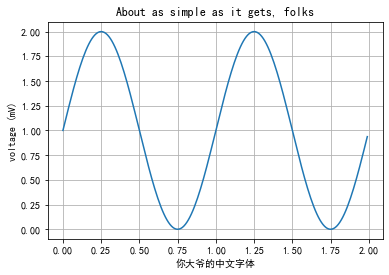

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='你大爷的中文字体', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()